In [60]:
import pandas as pd
import geopandas as gpd
import numpy as np
import math
import pickle
import datetime as dtdiq
from pathlib import Path
import json
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from shapely.geometry import shape, Point
from sklearn.neural_network import MLPClassifier, MLPRegressor

from train.variables import variables

In [61]:
root = Path('/Home/Users/ncaron/Bureau/Dual_Model_Research/csv')

#firepoint = pd.read_csv(dir_csv / 'firepoint' / 'fire_2018_2023.csv')
#firepoint['month'] = firepoint['date'].apply(lambda x : x.split('-')[1])

def get_month(x):
    return x.split(' ')[0].split('-')[1]


def get_year(x):
    return x.split(' ')[0].split('-')[0]


version = '7.0'
dir_dataset = Path(version)

dataset = pd.read_csv(dir_dataset / 'dataset_2023_calibrated.csv').sort_values(['creneau', 'cluster'])
#dataset = pd.read_csv(dir_dataset / 'test.csv').sort_values(['creneau', 'cluster'])
dataset[variables] = dataset[variables].astype(float)

classWeight = {}
fireWeight = {}

for c in dataset.classCalibrated.unique():
    classWeight[c] = (len(dataset[dataset['classCalibrated'] == 0]) / len(dataset[dataset['classCalibrated'] == c]))

fireWeight[0] = 1
fireWeight[1] = (len(dataset[dataset['isFire'] == 0]) / len(dataset[dataset['isFire'] == 1]))

dataset['weights_binary'] = dataset['isFire'].apply(lambda x : fireWeight[x])
dataset['weights_regressive'] = dataset['classCalibrated'].apply(lambda x : classWeight[x])

if 'osmnx' in dataset.columns:
    dataset.drop('osmnx', axis=1, inplace=True)

if 'NumberOfCities' in dataset.columns:
    dataset.drop('NumberOfCities', axis=1, inplace=True)

dataset_historic = dataset[dataset['year'] < 2023]
dataset = dataset[dataset['year'] == 2023]
#dataset = dataset[dataset['month'] > 5]
train = pd.read_csv(dir_dataset / 'train_multi_class.csv')
#dataset = dataset[(dataset['year'] >= 2023) & (dataset['creneau'] <= '2023-09-11')]
config = json.load( open(dir_dataset/ "config.json", "r"))
config["evaluationCluster"] = [int(c) for c in config["evaluationCluster"]]

/tmp/ipykernel_88708/3674521019.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset['weights_binary'] = dataset['isFire'].apply(lambda x : fireWeight[x])
/tmp/ipykernel_88708/3674521019.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset['weights_regressive'] = dataset['classCalibrated'].apply(lambda x : classWeight[x])


In [62]:
"""print(dataset.cluster.unique())
dataset.dropna(subset=variables, inplace=True)
dataset.cluster.unique()"""

'print(dataset.cluster.unique())\ndataset.dropna(subset=variables, inplace=True)\ndataset.cluster.unique()'

In [63]:
dataset_historic.month.unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., nan])

In [64]:
dataset.month.unique()

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [65]:
config["evaluationCluster"]

[]

In [66]:
dataset

,creneau,cluster,temp_0,dwpt_0,rhum_0,prcp_0,wdir_0,wspd_0,prec24h_0,dc_0,...,prec24h16_-5,fireInfluence_top1,fireInfluence_top2,fireInfluence_top3,classNonCalibrated,calibratedProba,classCalibrated,classCalibratedProba,weights_binary,weights_regressive
58729,2023-01-01,0,5.928433,-0.136352,65.178408,0.0,41.316167,5.687552,0.001293,21.911638,...,0.001293,-7.237009e-17,1.315820e-17,2.014553e-01,1,0.045269,0,0.029908,1.00000,1.000000
58730,2023-01-01,1,6.200393,2.997237,79.983483,0.0,319.579166,1.503700,0.099852,98.799872,...,0.099852,3.308244e-01,-6.579099e-17,1.315820e-17,0,0.018633,0,0.029908,1.00000,1.000000
58731,2023-01-01,2,6.200604,3.006635,80.031150,0.0,320.559157,1.492076,0.100199,99.315768,...,0.100199,9.210739e-17,-2.631640e-17,3.308244e-01,0,0.019103,0,0.029908,1.00000,1.000000
58732,2023-01-01,3,6.200904,3.007008,80.031505,0.0,320.551712,1.490545,0.100198,99.152162,...,0.100198,1.315820e-17,9.210739e-17,3.289550e-18,0,0.023732,0,0.029908,1.00000,1.000000
58733,2023-01-01,4,6.052469,-0.189067,64.326513,0.0,35.850729,5.862029,-0.000155,21.026716,...,-0.000155,-7.237009e-17,1.327062e+00,1.315820e-17,1,0.035022,0,0.029908,1.00000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66285,2023-09-10,775,27.096819,19.201363,62.055689,0.0,238.256049,4.874950,0.000000,341.049961,...,-0.112201,1.578100e-01,1.859903e-01,0.000000e+00,0,0.019572,0,0.029908,1.00000,1.000000
66286,2023-09-10,776,24.997334,17.827966,64.575531,0.0,263.212379,2.209689,0.000000,285.276014,...,0.748283,-2.273737e-17,0.000000e+00,1.859903e-01,1,0.081797,1,0.133643,8.83536,5.636467
66299,2023-09-10,777,25.456180,17.230093,60.362540,0.0,267.332336,2.463577,0.000000,273.370931,...,0.001577,2.322285e+00,1.578100e-01,0.000000e+00,1,0.071086,0,0.029908,8.83536,1.000000
66309,2023-09-10,778,22.610730,17.684519,73.670819,0.0,272.605406,2.928403,0.000000,373.036084,...,2.883729,1.859903e-01,2.267535e+00,7.514761e-02,0,0.016922,0,0.029908,1.00000,1.000000


In [67]:
from sklearn.calibration import calibration_curve

def expected_calibration_error(y, proba):
    """
    Calcule l'erreur de calibration : expected_calibration_error (ECE)
    """
    bin_count, bin_edges = np.histogram(proba, bins = 'auto')
    n_bins = len(bin_count)
    bin_edges[0] -= 1e-8 # because left edge is not included
    bin_id = np.digitize(proba, bin_edges, right = True) - 1
    print(n_bins)
    bin_ysum = np.bincount(bin_id, weights = y, minlength = n_bins)
    bin_probasum = np.bincount(bin_id, weights = proba, minlength = n_bins)
    bin_ymean = np.divide(bin_ysum, bin_count, out = np.zeros(n_bins), where = bin_count > 0)
    bin_probamean = np.divide(bin_probasum, bin_count, out = np.zeros(n_bins), where = bin_count > 0)
    ece = np.abs((bin_probamean - bin_ymean) * bin_count).sum() / len(proba)
    return n_bins, ece


def expected_calibration_error(true_labels, samples, bins=5):
    
    bin_count, bin_edges = np.histogram(samples, bins = 'auto')
    n_bins = len(bin_count)
    # uniform binning approach with M number of bins
    bin_boundaries = bin_edges
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    confidences = samples

    # get a boolean list of correct/false predictions
    accuracies = true_labels

    ece = np.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prob_in_bin = in_bin.mean()

        if prob_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].mean()
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = confidences[in_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prob_in_bin
    return n_bins, ece[0] * 100

In [68]:
dataset

,creneau,cluster,temp_0,dwpt_0,rhum_0,prcp_0,wdir_0,wspd_0,prec24h_0,dc_0,...,prec24h16_-5,fireInfluence_top1,fireInfluence_top2,fireInfluence_top3,classNonCalibrated,calibratedProba,classCalibrated,classCalibratedProba,weights_binary,weights_regressive
58729,2023-01-01,0,5.928433,-0.136352,65.178408,0.0,41.316167,5.687552,0.001293,21.911638,...,0.001293,-7.237009e-17,1.315820e-17,2.014553e-01,1,0.045269,0,0.029908,1.00000,1.000000
58730,2023-01-01,1,6.200393,2.997237,79.983483,0.0,319.579166,1.503700,0.099852,98.799872,...,0.099852,3.308244e-01,-6.579099e-17,1.315820e-17,0,0.018633,0,0.029908,1.00000,1.000000
58731,2023-01-01,2,6.200604,3.006635,80.031150,0.0,320.559157,1.492076,0.100199,99.315768,...,0.100199,9.210739e-17,-2.631640e-17,3.308244e-01,0,0.019103,0,0.029908,1.00000,1.000000
58732,2023-01-01,3,6.200904,3.007008,80.031505,0.0,320.551712,1.490545,0.100198,99.152162,...,0.100198,1.315820e-17,9.210739e-17,3.289550e-18,0,0.023732,0,0.029908,1.00000,1.000000
58733,2023-01-01,4,6.052469,-0.189067,64.326513,0.0,35.850729,5.862029,-0.000155,21.026716,...,-0.000155,-7.237009e-17,1.327062e+00,1.315820e-17,1,0.035022,0,0.029908,1.00000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66285,2023-09-10,775,27.096819,19.201363,62.055689,0.0,238.256049,4.874950,0.000000,341.049961,...,-0.112201,1.578100e-01,1.859903e-01,0.000000e+00,0,0.019572,0,0.029908,1.00000,1.000000
66286,2023-09-10,776,24.997334,17.827966,64.575531,0.0,263.212379,2.209689,0.000000,285.276014,...,0.748283,-2.273737e-17,0.000000e+00,1.859903e-01,1,0.081797,1,0.133643,8.83536,5.636467
66299,2023-09-10,777,25.456180,17.230093,60.362540,0.0,267.332336,2.463577,0.000000,273.370931,...,0.001577,2.322285e+00,1.578100e-01,0.000000e+00,1,0.071086,0,0.029908,8.83536,1.000000
66309,2023-09-10,778,22.610730,17.684519,73.670819,0.0,272.605406,2.928403,0.000000,373.036084,...,2.883729,1.859903e-01,2.267535e+00,7.514761e-02,0,0.016922,0,0.029908,1.00000,1.000000


In [69]:
dataset['month'] = dataset['creneau'].apply(lambda x : x.split('-')[1])
dataset.drop_duplicates(inplace=True)

In [70]:
dataset[variables] = dataset[variables].astype(float)

In [71]:
def get_cluster(x, y, cluster):
    return cluster.predict([[x, y]])[0]

#kmeans = pickle.load(open(root / departement / 'temporal' / 'cluster' / 'regClusterKMeans.pkl', 'rb'))
#firepoint['cluster'] = firepoint.apply(lambda x :get_cluster(x['latitude'], x['longitude'], kmeans), axis=1)

In [72]:
print(dataset['fireInfluence'].mean(), dataset['fireInfluence'].min(), dataset['fireInfluence'].max())

0.08932933360190265 9.146182109901298e-18 0.8311336056733064


<Axes: xlabel='year'>

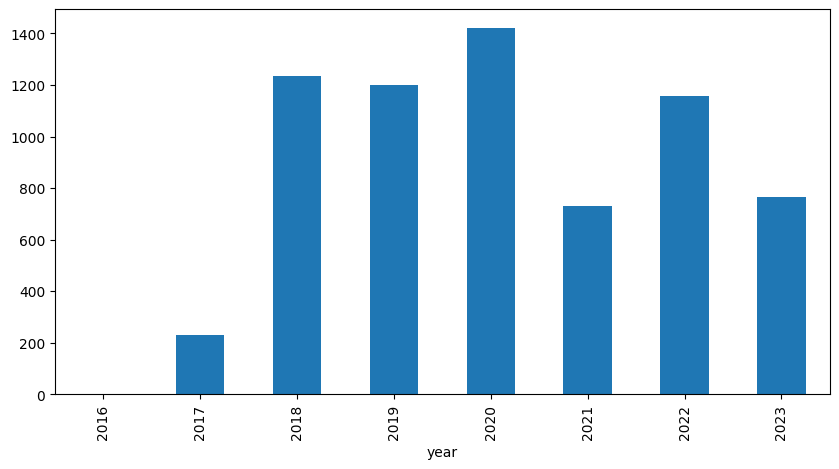

In [73]:
all_firepoint = pd.concat((dataset_historic, dataset))

fig, ax = plt.subplots(1, figsize=(10,5))
all_firepoint.groupby('year')['isFire'].sum().plot.bar()

<Axes: xlabel='year'>

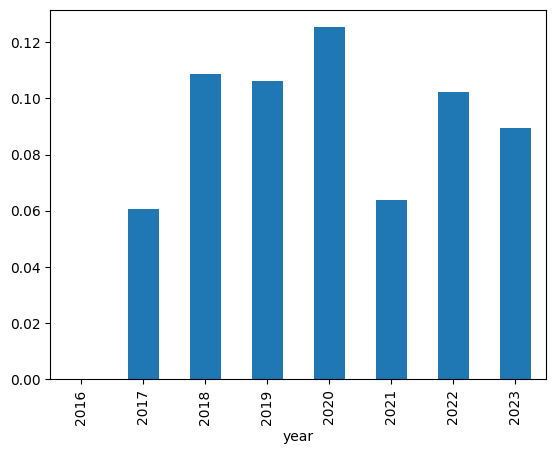

In [74]:
full_dataset = pd.concat((dataset_historic, dataset))

full_dataset.groupby('year')['fireInfluence'].mean().plot.bar()

<Axes: xlabel='year'>

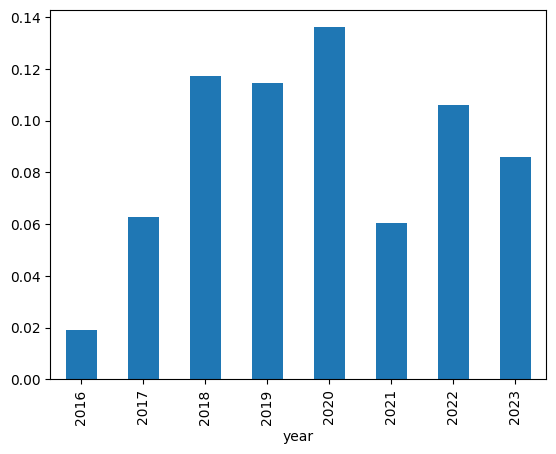

In [75]:
full_dataset = pd.concat((dataset_historic, dataset))

full_dataset.groupby('year')['calibratedProba'].mean().plot.bar()

/tmp/ipykernel_88708/2087407253.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_dataset['coef'] = 1


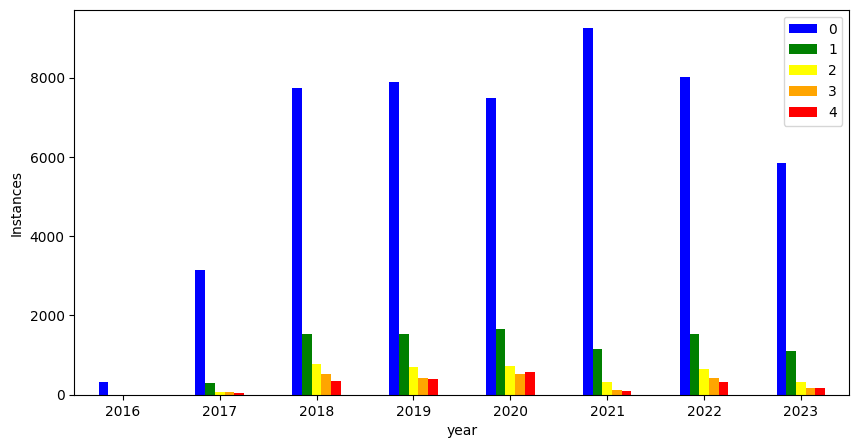

In [76]:
full_dataset['coef'] = 1

hist = pd.DataFrame(index=pd.MultiIndex.from_product([full_dataset.year.unique(), ['0'], ['1'], ['2'], ['3'], ['4']],  names=['year', '0', '1', '2', '3', '4']))
hist.reset_index(inplace=True)
hist.dropna(inplace=True)

gpb = full_dataset.groupby(['year', 'classCalibrated'])['coef'].sum()
for index, row in hist.iterrows():
    for c in ['0', '1', '2', '3', '4']:
        try:
            hist.loc[index, c] = gpb.loc[row['year'], int(c)]
        except:
            hist.loc[index, c] = 0
            
hist.index = hist.year
hist.drop('year', axis=1, inplace=True)
fig, ax = plt.subplots(1, figsize = (10,5))
hist.plot.bar(rot=0, color={"0": "blue", "1": "green", "2": "yellow", "3": "orange", "4": "red"}, ax=ax)
ax.set_xlabel('year')
ax.set_ylabel('Instances')
plt.show()

<Axes: xlabel='month'>

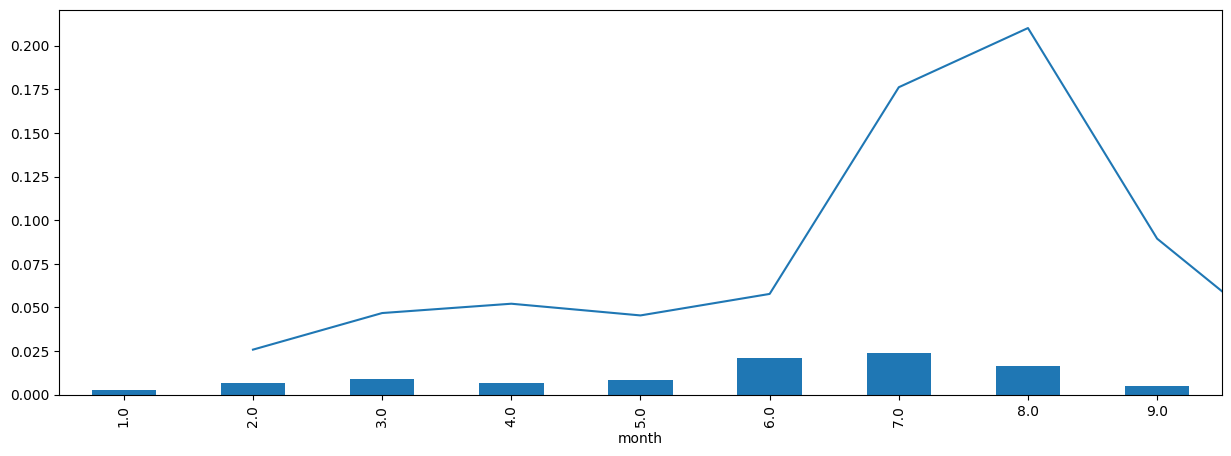

In [77]:
fig, ax = plt.subplots(1, figsize=(15,5))

grb = dataset.groupby('month')['calibratedProba'].mean()
grb.index = dataset.groupby('month')['isFire'].mean().index
grb.plot(ax=ax)
(dataset.groupby('month')['isFire'].sum() / len(dataset)).plot.bar(ax=ax)

In [78]:
fireWeight

{0: 1, 1: 8.835360427172946}

/tmp/ipykernel_88708/1457339504.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("Dark2")


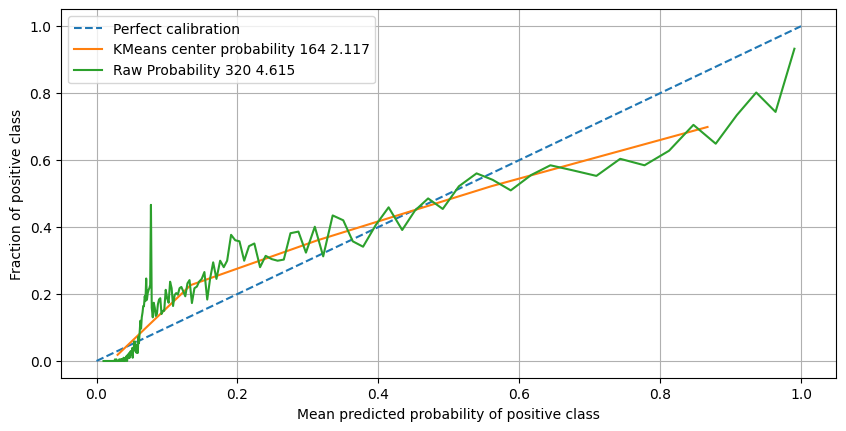

In [79]:
from sklearn.linear_model import LogisticRegression
from matplotlib.gridspec import GridSpec

dataset['calibratedProba'] = dataset['calibratedProba'].apply(lambda x : x if x > 0 else 0)
calibratedProba = full_dataset['calibratedProba'].values
classCenter = full_dataset['classCalibratedProba'].values

fig = plt.figure(figsize=(10,10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
ax_calibration_curve.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect calibration')
n_bins, ece = expected_calibration_error(full_dataset['isFire'], classCenter)
y_means, proba_means = calibration_curve(full_dataset['isFire'], classCenter, n_bins=n_bins, strategy='quantile')
ax_calibration_curve.plot(proba_means, y_means, label='KMeans center probability ' + str(n_bins) + " " + str(round(ece, 3)))

n_bins, ece = expected_calibration_error(full_dataset['isFire'], calibratedProba)
y_means, proba_means = calibration_curve(full_dataset['isFire'], calibratedProba, n_bins=n_bins, strategy='quantile')
ax_calibration_curve.plot(proba_means, y_means, label='Raw Probability ' + str(n_bins) + " " + str(round(ece, 3)))

ax_calibration_curve.set(xlabel="Mean predicted probability of positive class", ylabel="Fraction of positive class")
ax_calibration_curve.grid()
ax_calibration_curve.legend()

plt.savefig(dir_dataset / 'calibration_study_2023.png')

In [80]:
dataset['coef'] = 1

/tmp/ipykernel_88708/3837537811.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset['coef'] = 1


In [81]:
def classify_dsr(x):
    if x < 5:
        return 0
    if x < 10.5:
        return 1
    if x < 21.5:
        return 2
    if x < 34.5:
        return 3
    else:
        return 4

dataset['fwi'] = dataset['fwi_0']
dataset['classDSR'] = dataset['fwi'].apply(classify_dsr)

/tmp/ipykernel_88708/3279737074.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset['fwi'] = dataset['fwi_0']
/tmp/ipykernel_88708/3279737074.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset['classDSR'] = dataset['fwi'].apply(classify_dsr)


In [82]:
classes =  [0,1,2,3,4]
meanfireday = {}
percentfire = {}
percentfireInfire = {}

meanfiredayfwi = {}
percentfirefwi = {}
percentfireInfirefwi = {}

percentmean = 0
percentmeanfwi = 0

for c in classes:
    percentfire[c] = (dataset[(dataset['classCalibrated'] == c) & (dataset['isFire'] == 1)]['isFire'].sum() / dataset[(dataset['classCalibrated'] == c)]['coef'].sum()) * 100
    percentfireInfire[c] = dataset[(dataset['classCalibrated'] == c) & (dataset['isFire'] == 1)]['isFire'].sum() / dataset[(dataset['isFire'] == 1)]['coef'].sum() * 100

    percentmean += percentfire[c]
    percentfirefwi[c] = (dataset[(dataset['classDSR'] == c) & (dataset['isFire'] == 1)]['isFire'].sum() / dataset[(dataset['classDSR'] == c)]['coef'].sum()) * 100
    percentfireInfirefwi[c] = (dataset[(dataset['classDSR'] == c) & (dataset['isFire'] == 1)]['isFire'].sum() / dataset[(dataset['isFire'] == 1)]['coef'].sum()) * 100
    percentmeanfwi += percentfirefwi[c]

percentfire, percentfireInfire

({0: 2.391118701964133,
  1: 25.885558583106267,
  2: 47.096774193548384,
  3: 49.696969696969695,
  4: 70.44025157232704},
 {0: 18.30065359477124,
  1: 37.254901960784316,
  2: 19.084967320261438,
  3: 10.718954248366012,
  4: 14.640522875816995})

In [83]:
dataset.month.unique()

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [84]:
hist

,0,1,2,3,4
year,,,,,
2016,310,0,0,0,0
2017,3145,308,81,74,42
2018,7748,1531,782,533,356
2019,7901,1523,691,428,407
2020,7487,1656,720,534,583
2021,9252,1162,332,119,85
2022,8010,1538,649,415,318
2023,5855,1101,310,165,159


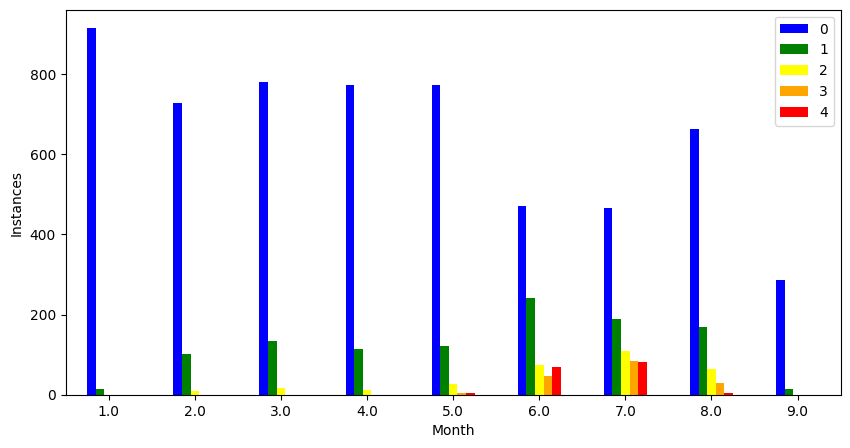

In [85]:
hist = pd.DataFrame(index=pd.MultiIndex.from_product([dataset.month.unique(), ['0'], ['1'], ['2'], ['3'], ['4']],  names=['month', '0', '1', '2', '3', '4']))
hist.reset_index(inplace=True)
hist.dropna(inplace=True)

gpb = dataset.groupby(['month', 'classCalibrated'])['coef'].sum()
for index, row in hist.iterrows():
    for c in ['0', '1', '2', '3', '4']:
        try:
            hist.loc[index, c] = gpb.loc[row['month'], int(c)]
        except:
            hist.loc[index, c] = 0
            
hist.index = hist.month
hist.drop('month', axis=1, inplace=True)
fig, ax = plt.subplots(1, figsize = (10,5))
hist.plot.bar(rot=0, color={"0": "blue", "1": "green", "2": "yellow", "3": "orange", "4": "red"}, ax=ax)
ax.set_xlabel('Month')
ax.set_ylabel('Instances')
plt.show()

In [86]:
dataset.dropna(subset=variables, inplace=True)
scaler = pickle.load(open(dir_dataset / 'scaler_origin.pkl', 'rb'))
dataset[variables] = scaler.transform(dataset[variables])
dataset.to_csv(dir_dataset / 'test_2023.csv')

In [87]:
dataset = pd.read_csv(dir_dataset / 'test_2023.csv')

In [88]:
from sklearn.metrics import log_loss

loglossProba = np.zeros(shape=(len(dataset), 2))
loglossProba[:,0] = 1 - dataset['calibratedProba'].values
loglossProba[:,1] = dataset['calibratedProba'].values

print(log_loss(dataset['isFire'].values, loglossProba, sample_weight=dataset['weights_binary']))

loglossProba = np.zeros(shape=(len(dataset[dataset['isFire'] == 1]), 2))
loglossProba[:,0] = 1 - dataset[dataset['isFire'] == 1]['calibratedProba'].values
loglossProba[:,1] = dataset[dataset['isFire'] == 1]['calibratedProba'].values

print(log_loss(dataset[dataset['isFire'] == 1]['isFire'].values, loglossProba, sample_weight=dataset[dataset['isFire'] == 1]['weights_binary'], labels=[0,1]))

NameError: name 'log_loss' is not defined

In [ ]:
dataset.dropna(subset=variables)

,Unnamed: 0.1,creneau,cluster,temp_0,dwpt_0,rhum_0,prcp_0,wdir_0,wspd_0,prec24h_0,...,classNonCalibrated,calibratedProba,classCalibrated,classCalibratedProba,weights_binary,weights_regressive,weights,coef,fwi,classDSR
0,58729,2023-01-01,0,-0.694759,-0.846396,0.151558,0.0,-0.893134,0.738110,-0.001047,...,1,0.045269,0,0.029908,1.00000,1.000000,1.00000,1,0.632652,0
1,58730,2023-01-01,1,-0.673702,-0.491102,0.650090,0.0,0.673038,-0.651815,0.045650,...,0,0.018633,0,0.029908,1.00000,1.000000,1.00000,1,0.150309,0
2,58731,2023-01-01,2,-0.673686,-0.490037,0.651695,0.0,0.678554,-0.655676,0.045814,...,0,0.019103,0,0.029908,1.00000,1.000000,1.00000,1,0.148867,0
3,58732,2023-01-01,3,-0.673662,-0.489994,0.651707,0.0,0.678512,-0.656185,0.045814,...,0,0.023732,0,0.029908,1.00000,1.000000,1.00000,1,0.148829,0
4,58733,2023-01-01,4,-0.685155,-0.852373,0.122872,0.0,-0.923896,0.796073,-0.001734,...,1,0.035022,0,0.029908,1.00000,1.000000,1.00000,1,0.664821,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7585,66285,2023-09-10,775,0.944269,1.346161,0.046406,0.0,0.215320,0.468154,-0.001660,...,0,0.019572,0,0.029908,1.00000,1.000000,1.00000,1,10.754922,2
7586,66286,2023-09-10,776,0.781710,1.190441,0.131257,0.0,0.355784,-0.417277,-0.001660,...,1,0.081797,1,0.133643,8.83536,5.636467,8.83536,1,6.645360,1
7587,66299,2023-09-10,777,0.817237,1.122653,-0.010607,0.0,0.378973,-0.332932,-0.001660,...,1,0.071086,0,0.029908,8.83536,1.000000,8.83536,1,6.936421,1
7588,66309,2023-09-10,778,0.596920,1.174177,0.437523,0.0,0.408651,-0.178512,-0.001660,...,0,0.016922,0,0.029908,1.00000,1.000000,1.00000,1,7.214906,1


### Model

In [ ]:
import joblib
import pickle
from xgboost import XGBClassifier

"""### Multi class
ty = 'xgboost_multi_class'
model_version = '1.0'

dir_model = dir_dataset / 'output' / ty / model_version / 'model'
name = model_version + '.joblib'
model = joblib.load(dir_model / name)
#model = pickle.load(open(dir_model / name, 'rb'))"""

### Binary
ty = 'xgboost_binary'
model_version = '1.0'
model_type = model_version+''

dir_model = dir_dataset / 'output' / ty
name = ty + '.joblib'
model_binary = joblib.load(dir_model / name)
#model_binary = pickle.load(open(dir_model / name, 'rb'))

### Quantile
"""ty = 'xgboost_quantile'
model_version = '1.0'

dir_model = dir_dataset / 'output' / ty 
name = ty + '.joblib'
model_quantile = joblib.load(dir_model / name)"""

### Reg
ty = 'NGBoost_regressive'
model_version = '1.0'

dir_model = dir_dataset / 'output' / ty
name = ty + '.joblib'
model_reg = joblib.load(dir_model / name)
#model_reg = pickle.load(open(dir_model / name, 'rb'))

In [ ]:
"""def re_discretize(discrete_values, values_to_discretize):

    insertion_index = np.searchsorted(discrete_values, values_to_discretize)
 
    index_closest_lower = (insertion_index - 1).clip(min=0)
    index_closest_upper = insertion_index.clip(max=len(discrete_values) - 1)


    closest_indexes = np.vstack((index_closest_lower, index_closest_upper))
    closest_values = np.take(discrete_values, closest_indexes)
    shortest_distances = abs(closest_values - values_to_discretize)

    nearest_value = shortest_distances.argmin(axis=0)
    discretized_values = closest_values[
        nearest_value, np.arange(len(values_to_discretize))
    ]

    return discretized_values


discreteVar = ['Canicule', 'match_LGF1',
            'match_CL',
            'match_LGF1-2',
            'match_LGF1-4',
            'match_LGF1-6',
            'match_LGF1-8',
            'match_LGF1-10',
            'match_LGF1-12',
            'match_CL-2',
            'match_CL-4',
            'match_CL-6',
            'match_CL-8',
            'match_CL-10',
            'match_CL-12', 'bankHolidays', 'bankHolidaysEve', 'bankHolidaysEveEve', 'holidays',
            'holidaysEve', 'holidaysEveEve', 'holidaysLastDay', 'holidaysLastLastDay', 'confinement1', 'confinement2', 'ramadan', 'dayofweek',
            'month', 'dayofyear']

for discrete_var in discreteVar:
    dataset[discrete_var] = re_discretize(np.unique(train[discrete_var]), dataset[discrete_var].values)
    #print(discrete_var, np.unique(train_copy[discrete_var]), np.unique(train[discrete_var]))
    print(discrete_var, np.unique(train[discrete_var]), np.unique(dataset[discrete_var]))"""

"def re_discretize(discrete_values, values_to_discretize):\n\n    insertion_index = np.searchsorted(discrete_values, values_to_discretize)\n \n    index_closest_lower = (insertion_index - 1).clip(min=0)\n    index_closest_upper = insertion_index.clip(max=len(discrete_values) - 1)\n\n\n    closest_indexes = np.vstack((index_closest_lower, index_closest_upper))\n    closest_values = np.take(discrete_values, closest_indexes)\n    shortest_distances = abs(closest_values - values_to_discretize)\n\n    nearest_value = shortest_distances.argmin(axis=0)\n    discretized_values = closest_values[\n        nearest_value, np.arange(len(values_to_discretize))\n    ]\n\n    return discretized_values\n\n\ndiscreteVar = ['Canicule', 'match_LGF1',\n            'match_CL',\n            'match_LGF1-2',\n            'match_LGF1-4',\n            'match_LGF1-6',\n            'match_LGF1-8',\n            'match_LGF1-10',\n            'match_LGF1-12',\n            'match_CL-2',\n            'match_CL-4',\n   

### Quantile

In [ ]:
#dataset['predict_0.05'] = model_quantile.predict(dataset[variables])[:,0]
#dataset['predict_0.5'] = model_quantile.predict(dataset[variables])[:,1]
#dataset['predict_0.95'] = model_quantile.predict(dataset[variables])[:,2]

dataset['predict_0.05'] = 0
dataset['predict_0.5'] = 0
dataset['predict_0.95'] = 0

dataset['predict_reg'] = model_reg.predict(dataset[variables])
dataset['predict_reg'] = dataset['predict_reg'].apply(lambda x : 0 if x < 0 else x)

### Classification

In [ ]:
print(len(dataset))

dataset.dropna(subset=variables, inplace=True)

print(len(dataset))

7590
7590


In [ ]:
from sklearn.cluster import KMeans

kmeansClass = pickle.load(open(dir_dataset / 'classifier_calibrated.pkl', 'rb'))
kcc = np.sort(kmeansClass.cluster_centers_.reshape(-1))
n_class = 5
kcc2class = {}
value4class = {}

for i in range(n_class):
    arg = np.where(kmeansClass.cluster_centers_[:,0] == kcc[i])[0]
    print(arg, i)
    kcc2class[arg[0]] = i
    value4class[arg[0]] = i

def get_class_center_from_prediction(x):
    return kmeansClass.cluster_centers_[x][0]

def get_class(x):
    cluster = kmeansClass.predict([[x]])[0]
    return value4class[cluster]


"""dataset['class_multi_class'] = model.predict(dataset[variables])
dataset['predict_multi_class'] = dataset['class_multi_class'].apply(get_class_center_from_prediction)"""

dataset['predict_binary'] = model_binary.predict_proba(dataset[variables])[:,1]
dataset['isFirePred'] = model_binary.predict(dataset[variables])

"""unknowdataset['class_multi_class'] = model.predict(unknowdataset[variables])
unknowdataset['predict_multi_class'] = unknowdataset['class_multi_class'].apply(get_class_center_from_prediction)

unknowdataset['predict_binary'] = model_binary.predict_proba(unknowdataset[variables])[:,1]
unknowdataset['isFirePred'] = model_binary.predict(unknowdataset[variables])"""

#### Binary class
"""n_class = 5

kmeansClassBin = KMeans(n_clusters=n_class, random_state=0).fit(dataset['predict_binary'].values.reshape(-1,1).astype(float))
print(kmeansClassBin.cluster_centers_)
kcc = np.sort(kmeansClassBin.cluster_centers_.reshape(-1))
kcc2class = {}

value4class = {}

for i in range(n_class):
    arg = np.where(kmeansClassBin.cluster_centers_[:,0] == kcc[i])[0]
    kcc2class[arg[0]] = i
    value4class[arg[0]] = i

def classify_kmeans(x):
    result = np.copy(x)
    clusters = np.unique(x)
    print(clusters)
    for c in clusters:
        maskC = np.argwhere(x == c)
        val = value4class[c]
        result[maskC] = val
    return result

def get_class_bin(x):
    cluster = kmeansClassBin.predict([[x]])[0]
    return value4class[cluster]"""

dataset['class_binary'] = dataset['predict_binary'].apply(get_class)
"""unknowdataset['class_binary'] = unknowdataset['predict_binary'].apply(get_class)"""


#### Reg class

"""def get_class_reg(x):
    cluster = kmeansClassReg.predict([[x]])[0]
    return value4class[cluster]

kmeansClassReg = KMeans(n_clusters=n_class, random_state=0).fit(dataset['predict_reg'].values.reshape(-1,1).astype(float))
print(kmeansClassReg.cluster_centers_)
kcc = np.sort(kmeansClassReg.cluster_centers_.reshape(-1))
kcc2class = {}

value4class = {}

for i in range(n_class):
    arg = np.where(kmeansClassReg.cluster_centers_[:,0] == kcc[i])[0]
    kcc2class[arg[0]] = i
    value4class[arg[0]] = i"""

dataset['class_reg'] = dataset['predict_reg'].apply(get_class)
"""unknowdataset['class_reg'] = unknowdataset['predict_reg'].apply(get_class)"""

[1] 0
[0] 1
[4] 2
[3] 3
[2] 4


"unknowdataset['class_reg'] = unknowdataset['predict_reg'].apply(get_class)"

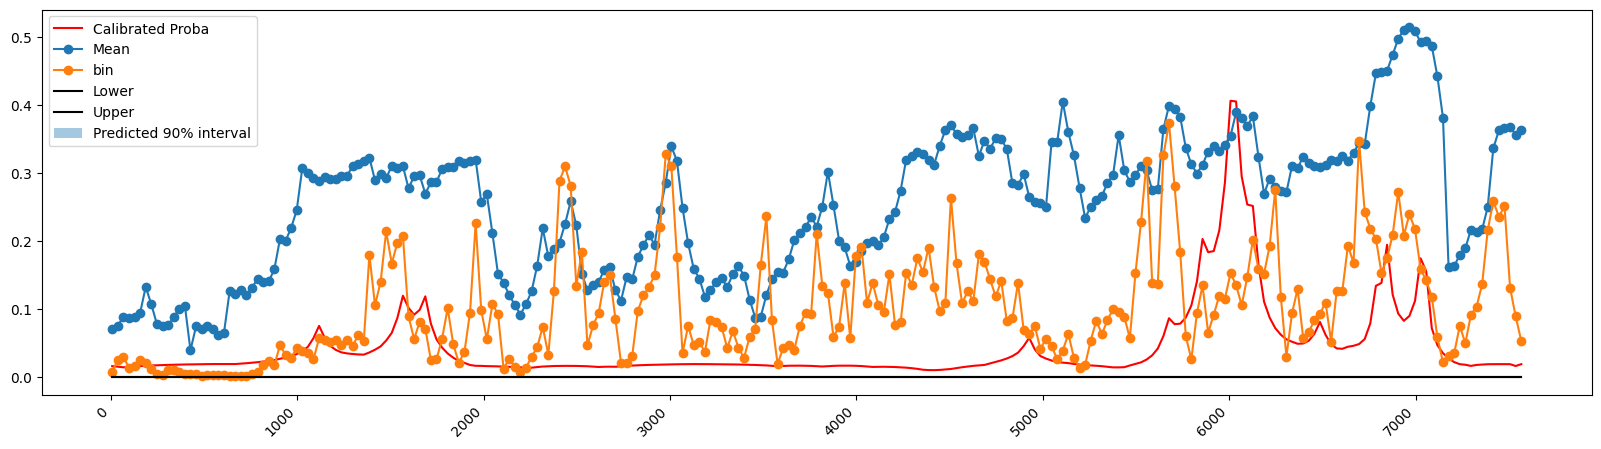

In [ ]:
dataset252 = dataset[(dataset['departement'] == 1) & (dataset['cluster'] == 7)]
fig, ax = plt.subplots(1, figsize = (20,5))

plt.plot(dataset252.index.values, dataset252.calibratedProba.values, 'r-', label='Calibrated Proba')
plt.plot(dataset252.index.values, dataset252.predict_reg.values, 'o-', label='Mean')
plt.plot(dataset252.index.values, dataset252.predict_binary.values, 'o-', label='bin')
#plt.plot(dataset252.index.values, dataset252.predict_05.values, 'r-', label='Median')
plt.plot(dataset252.index.values, dataset252['predict_0.05'].values, 'k-', label='Lower')
plt.plot(dataset252.index.values, dataset252['predict_0.95'].values, 'k-', label='Upper')

plt.fill_between(
            dataset252.index.values, dataset252['predict_0.05'].values, dataset252['predict_0.95'].values, alpha=0.4, label="Predicted 90% interval"
    )

plt.xticks(rotation=45, ha='right')
plt.legend()

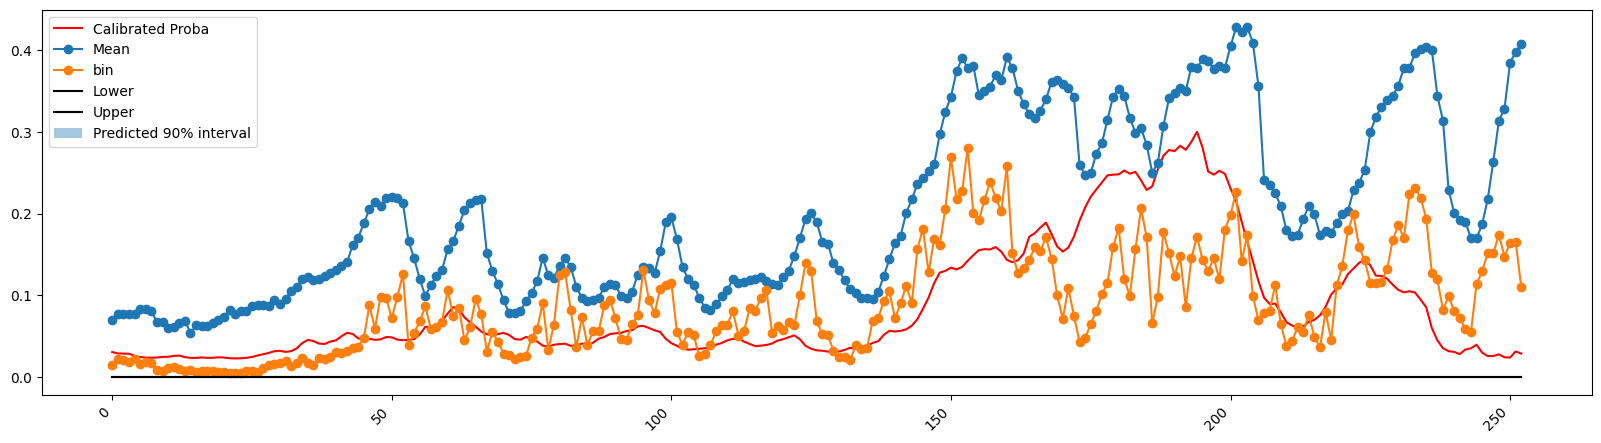

In [ ]:
dataset252 = dataset.groupby('creneau')[['predict_reg', 'predict_0.05', 'predict_0.5', 'predict_0.95', 'calibratedProba', 'predict_binary']].mean().reset_index(drop=True)

fig, ax = plt.subplots(1, figsize = (20,5))

plt.plot(dataset252.index.values, dataset252.calibratedProba.values, 'r-', label='Calibrated Proba')
plt.plot(dataset252.index.values, dataset252.predict_reg.values, 'o-', label='Mean')
plt.plot(dataset252.index.values, dataset252.predict_binary.values, 'o-', label='bin')
#plt.plot(dataset252.index.values, dataset252.predict_05.values, 'r-', label='Median')
plt.plot(dataset252.index.values, dataset252['predict_0.05'].values, 'k-', label='Lower')
plt.plot(dataset252.index.values, dataset252['predict_0.95'].values, 'k-', label='Upper')

plt.fill_between(dataset252.index.values, dataset252['predict_0.05'].values, dataset252['predict_0.95'].values, alpha=0.4, label="Predicted 90% interval")

plt.xticks(rotation=45, ha='right')
plt.legend()

In [ ]:
classes =  [0,1,2,3,4]
percentfire = {}
percentfireInfire = {}

percentfirebin = {}
percentfireInfirebin = {}

percentfirereg = {}
percentfireInfirereg = {}

percentmean = 0

for c in classes:
    """if dataset[(dataset['class_multi_class'] == c)]['coef'].sum() == 0:
        percentfire[c] = 0
    else:
        percentfire[c] = (dataset[(dataset['class_multi_class'] == c) & (dataset['isFire'] == 1)]['isFire'].sum() / dataset[(dataset['class_multi_class'] == c)]['coef'].sum()) * 100
    percentfireInfire[c] = dataset[(dataset['class_multi_class'] == c) & (dataset['isFire'] == 1)]['isFire'].sum() / dataset[(dataset['isFire'] == 1)]['coef'].sum() * 100"""

    if dataset[(dataset['class_binary'] == c)]['coef'].sum() == 0:
        percentfirebin[c] = 0
    else:
        percentfirebin[c] = (dataset[(dataset['class_binary'] == c) & (dataset['isFire'] == 1)]['isFire'].sum() / dataset[(dataset['class_binary'] == c)]['coef'].sum()) * 100
    percentfireInfirebin[c] = dataset[(dataset['class_binary'] == c) & (dataset['isFire'] == 1)]['isFire'].sum() / dataset[(dataset['isFire'] == 1)]['coef'].sum() * 100
    
    if dataset[(dataset['class_reg'] == c)]['coef'].sum() == 0:
        percentfirereg[c] = 0
    else:
        percentfirereg[c] = (dataset[(dataset['class_reg'] == c) & (dataset['isFire'] == 1)]['isFire'].sum() / dataset[(dataset['class_reg'] == c)]['coef'].sum()) * 100
    percentfireInfirereg[c] = dataset[(dataset['class_reg'] == c) & (dataset['isFire'] == 1)]['isFire'].sum() / dataset[(dataset['isFire'] == 1)]['coef'].sum() * 100
    
percentfire, percentfireInfire

({}, {})

In [ ]:
percentfirebin, percentfireInfirebin

({0: 6.238569396464133,
  1: 15.025906735751295,
  2: 21.766561514195583,
  3: 27.450980392156865,
  4: 66.66666666666666},
 {0: 40.130718954248366,
  1: 37.908496732026144,
  2: 18.03921568627451,
  3: 3.6601307189542487,
  4: 0.261437908496732})

In [ ]:
percentfirereg, percentfireInfirereg

({0: 3.9382650345928685,
  1: 7.348560079443893,
  2: 14.83489403647117,
  3: 24.637681159420293,
  4: 37.5},
 {0: 9.673202614379086,
  1: 29.01960784313726,
  2: 39.34640522875817,
  3: 20.0,
  4: 1.9607843137254901})

In [ ]:
percentfirefwi, percentfireInfirefwi

({0: 7.0097416349004655,
  1: 11.4853195164076,
  2: 14.70019342359768,
  3: 20.588235294117645,
  4: 30.612244897959183},
 {0: 43.26797385620915,
  1: 17.38562091503268,
  2: 19.869281045751634,
  3: 15.555555555555555,
  4: 3.9215686274509802})

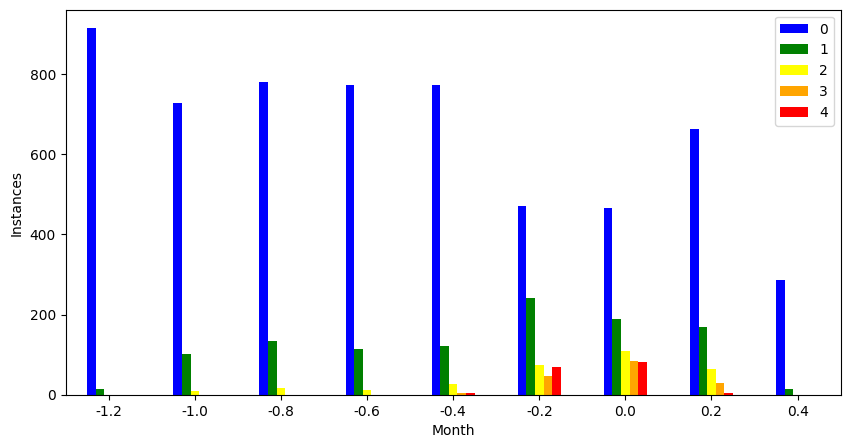

In [ ]:
hist = pd.DataFrame(index=pd.MultiIndex.from_product([dataset.month.unique(), ['0'], ['1'], ['2'], ['3'], ['4']],  names=['month', '0', '1', '2', '3', '4']))
hist.reset_index(inplace=True)
hist.dropna(inplace=True)

gpb = dataset.groupby(['month', 'classCalibrated'])['coef'].sum()
for index, row in hist.iterrows():
    for c in ['0', '1', '2', '3', '4']:
        try:
            hist.loc[index, c] = gpb.loc[row['month'], int(c)]
        except:
            hist.loc[index, c] = 0
            
hist.index = hist.month
hist.drop('month', axis=1, inplace=True)
fig, ax = plt.subplots(1, figsize = (10,5))
hist.plot.bar(rot=0, color={"0": "blue", "1": "green", "2": "yellow", "3": "orange", "4": "red"}, ax=ax)
ax.set_xlabel('Month')
ax.set_ylabel('Instances')
plt.show()

In [ ]:
"""hist = pd.DataFrame(index=pd.MultiIndex.from_product([dataset.month.unique(), ['0'], ['1'], ['2'], ['3'], ['4'], ['isFire']],  names=['month', '0', '1', '2', '3', '4', 'numFire']))
hist.reset_index(inplace=True)
hist.dropna(inplace=True)

dataset['coef'] = 1

gpb = dataset.groupby(['month', 'class_multi_class'])['coef'].sum()
for index, row in hist.iterrows():
    for c in ['0', '1', '2', '3', '4']:
        try:
            hist.loc[index, c] = gpb.loc[row['month'], int(c)]
        except:
            hist.loc[index, c] = 0

gpb = dataset.groupby(['month'])['isFire'].sum()
for index, row in hist.iterrows():
        val = gpb.loc[row['month']]
        hist.loc[index, 'isFire'] = val

hist.index = hist.month
hist.drop('month', axis=1, inplace=True)

fig, ax = plt.subplots(1, figsize = (10,5))
hist.plot.bar(rot=0, color={"0": "blue", "1": "green", "2": "yellow", "3": "orange", "4": "red", 'isFire' : 'black'}, ax=ax)
ax.set_xlabel('month')
ax.set_ylabel('Instances')
plt.show()"""

'hist = pd.DataFrame(index=pd.MultiIndex.from_product([dataset.month.unique(), [\'0\'], [\'1\'], [\'2\'], [\'3\'], [\'4\'], [\'isFire\']],  names=[\'month\', \'0\', \'1\', \'2\', \'3\', \'4\', \'numFire\']))\nhist.reset_index(inplace=True)\nhist.dropna(inplace=True)\n\ndataset[\'coef\'] = 1\n\ngpb = dataset.groupby([\'month\', \'class_multi_class\'])[\'coef\'].sum()\nfor index, row in hist.iterrows():\n    for c in [\'0\', \'1\', \'2\', \'3\', \'4\']:\n        try:\n            hist.loc[index, c] = gpb.loc[row[\'month\'], int(c)]\n        except:\n            hist.loc[index, c] = 0\n\ngpb = dataset.groupby([\'month\'])[\'isFire\'].sum()\nfor index, row in hist.iterrows():\n        val = gpb.loc[row[\'month\']]\n        hist.loc[index, \'isFire\'] = val\n\nhist.index = hist.month\nhist.drop(\'month\', axis=1, inplace=True)\n\nfig, ax = plt.subplots(1, figsize = (10,5))\nhist.plot.bar(rot=0, color={"0": "blue", "1": "green", "2": "yellow", "3": "orange", "4": "red", \'isFire\' : \'black\

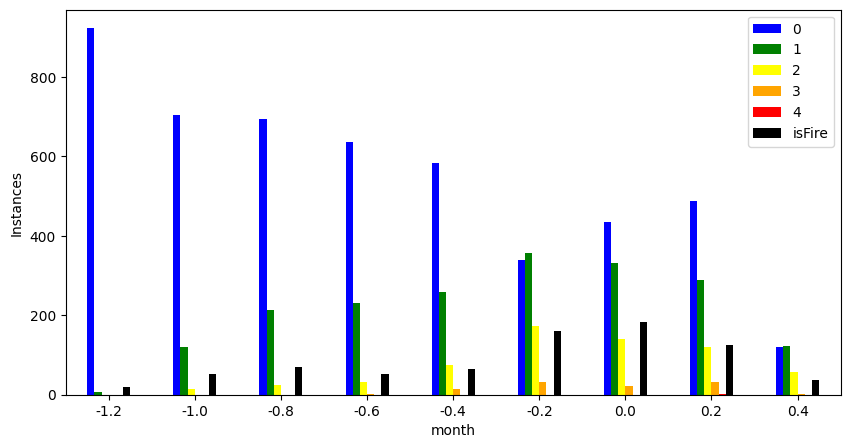

In [ ]:
hist = pd.DataFrame(index=pd.MultiIndex.from_product([dataset.month.unique(), ['0'], ['1'], ['2'], ['3'], ['4'], ['isFire']],  names=['month', '0', '1', '2', '3', '4', 'numFire']))
hist.reset_index(inplace=True)
hist.dropna(inplace=True)

dataset['coef'] = 1

gpb = dataset.groupby(['month', 'class_binary'])['coef'].sum()
for index, row in hist.iterrows():
    for c in ['0', '1', '2', '3', '4']:
        try:
            hist.loc[index, c] = gpb.loc[row['month'], int(c)]
        except:
            hist.loc[index, c] = 0

gpb = dataset.groupby(['month'])['isFire'].sum()
for index, row in hist.iterrows():
        val = gpb.loc[row['month']]
        hist.loc[index, 'isFire'] = val

hist.index = hist.month
hist.drop('month', axis=1, inplace=True)

fig, ax = plt.subplots(1, figsize = (10,5))
hist.plot.bar(rot=0, color={"0": "blue", "1": "green", "2": "yellow", "3": "orange", "4": "red", 'isFire' : 'black'}, ax=ax)
ax.set_xlabel('month')
ax.set_ylabel('Instances')
plt.show()

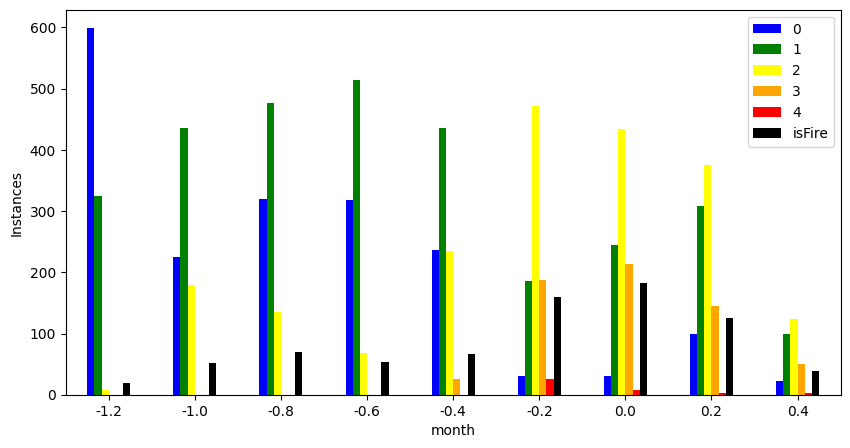

In [ ]:
hist = pd.DataFrame(index=pd.MultiIndex.from_product([dataset.month.unique(), ['0'], ['1'], ['2'], ['3'], ['4'], ['isFire']],  names=['month', '0', '1', '2', '3', '4', 'numFire']))
hist.reset_index(inplace=True)
hist.dropna(inplace=True)

dataset['coef'] = 1

gpb = dataset.groupby(['month', 'class_reg'])['coef'].sum()
for index, row in hist.iterrows():
    for c in ['0', '1', '2', '3', '4']:
        try:
            hist.loc[index, c] = gpb.loc[row['month'], int(c)]
        except:
            hist.loc[index, c] = 0

gpb = dataset.groupby(['month'])['isFire'].sum()
for index, row in hist.iterrows():
        val = gpb.loc[row['month']]
        hist.loc[index, 'isFire'] = val

hist.index = hist.month
hist.drop('month', axis=1, inplace=True)

fig, ax = plt.subplots(1, figsize = (10,5))
hist.plot.bar(rot=0, color={"0": "blue", "1": "green", "2": "yellow", "3": "orange", "4": "red", 'isFire' : 'black'}, ax=ax)
ax.set_xlabel('month')
ax.set_ylabel('Instances')
plt.show()

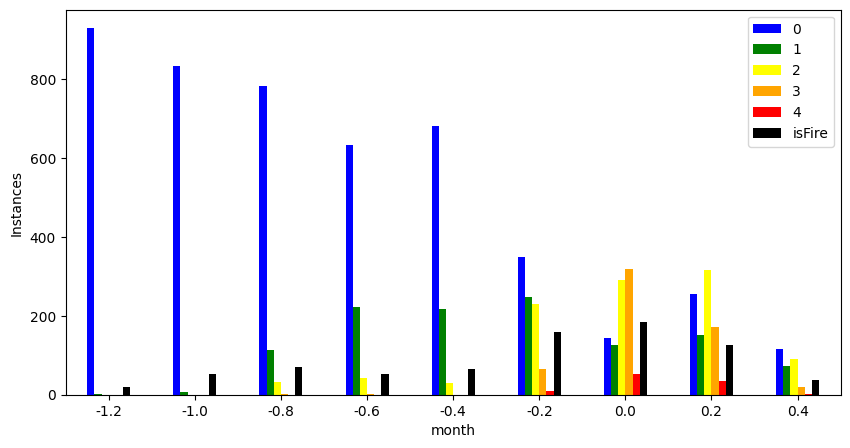

In [ ]:
hist = pd.DataFrame(index=pd.MultiIndex.from_product([dataset.month.unique(), ['0'], ['1'], ['2'], ['3'], ['4'], ['isFire']],  names=['month', '0', '1', '2', '3', '4', 'numFire']))
hist.reset_index(inplace=True)
hist.dropna(inplace=True)

dataset['coef'] = 1

gpb = dataset.groupby(['month', 'classDSR'])['coef'].sum()
for index, row in hist.iterrows():
    for c in ['0', '1', '2', '3', '4']:
        try:
            hist.loc[index, c] = gpb.loc[row['month'], int(c)]
        except:
            hist.loc[index, c] = 0

gpb = dataset.groupby(['month'])['isFire'].sum()
for index, row in hist.iterrows():
        val = gpb.loc[row['month']]
        hist.loc[index, 'isFire'] = val

hist.index = hist.month
hist.drop('month', axis=1, inplace=True)

fig, ax = plt.subplots(1, figsize = (10,5))
hist.plot.bar(rot=0, color={"0": "blue", "1": "green", "2": "yellow", "3": "orange", "4": "red", 'isFire' : 'black'}, ax=ax)
ax.set_xlabel('month')
ax.set_ylabel('Instances')
plt.show()

In [ ]:
gpb = dataset.groupby(['cluster'])['isFire'].sum()
gpb

cluster
0      15
1      35
2      37
3      43
4      28
5      23
6      33
7      14
8      33
9      33
240     8
241    41
242    37
243    16
244    12
245    12
246    26
247    14
248    11
249    15
770     9
771    17
772    41
773    50
774    34
775    45
776    14
777    31
778    25
779    13
Name: isFire, dtype: int64

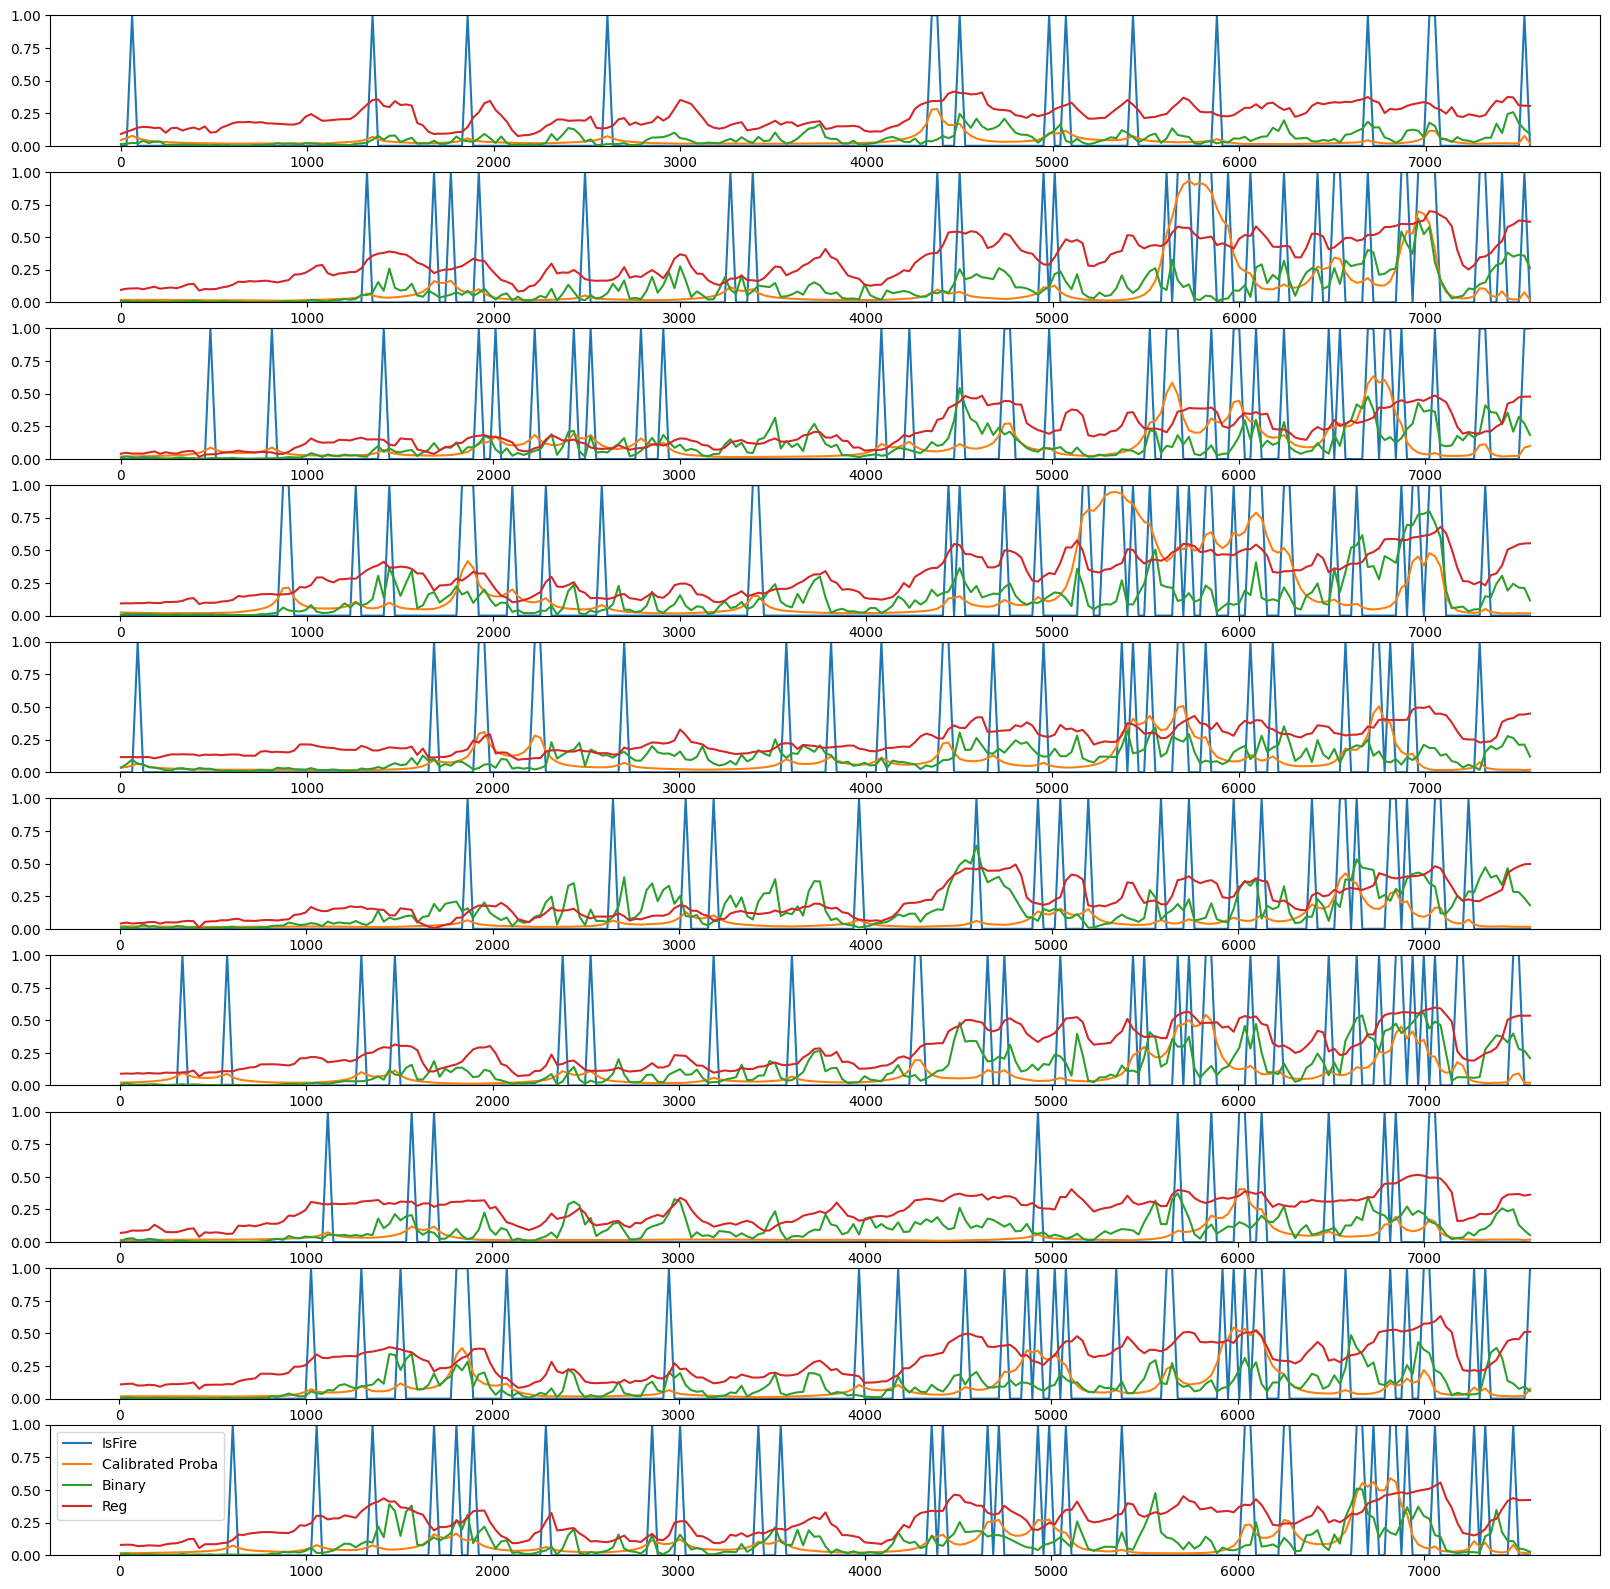

In [ ]:
dataset252 = dataset[(dataset['departement'] == 1)]

clusterId = dataset252['cluster'].unique()

fig, ax = plt.subplots(len(clusterId), figsize = (20,20))

for i, cID in enumerate(clusterId):
    dataset252_ = dataset252[(dataset252['cluster'] == cID)]
    ax[i].set_ylim([0, 1])
    ax[i].plot(dataset252_.index.values, dataset252_.isFire.values, label='IsFire')
    ax[i].plot(dataset252_.index.values, dataset252_.calibratedProba.values, label='Calibrated Proba')
    ax[i].plot(dataset252_.index.values, dataset252_.predict_binary.values, label='Binary')
    ax[i].plot(dataset252_.index.values, dataset252_.predict_reg.values, label='Reg')
    #ax[i].plot(dataset252_.index.values, dataset252_.predict_multi_class.values, label='Multi class')
    #ax[i].set_xticks(rotation=45, ha='right')
plt.legend()

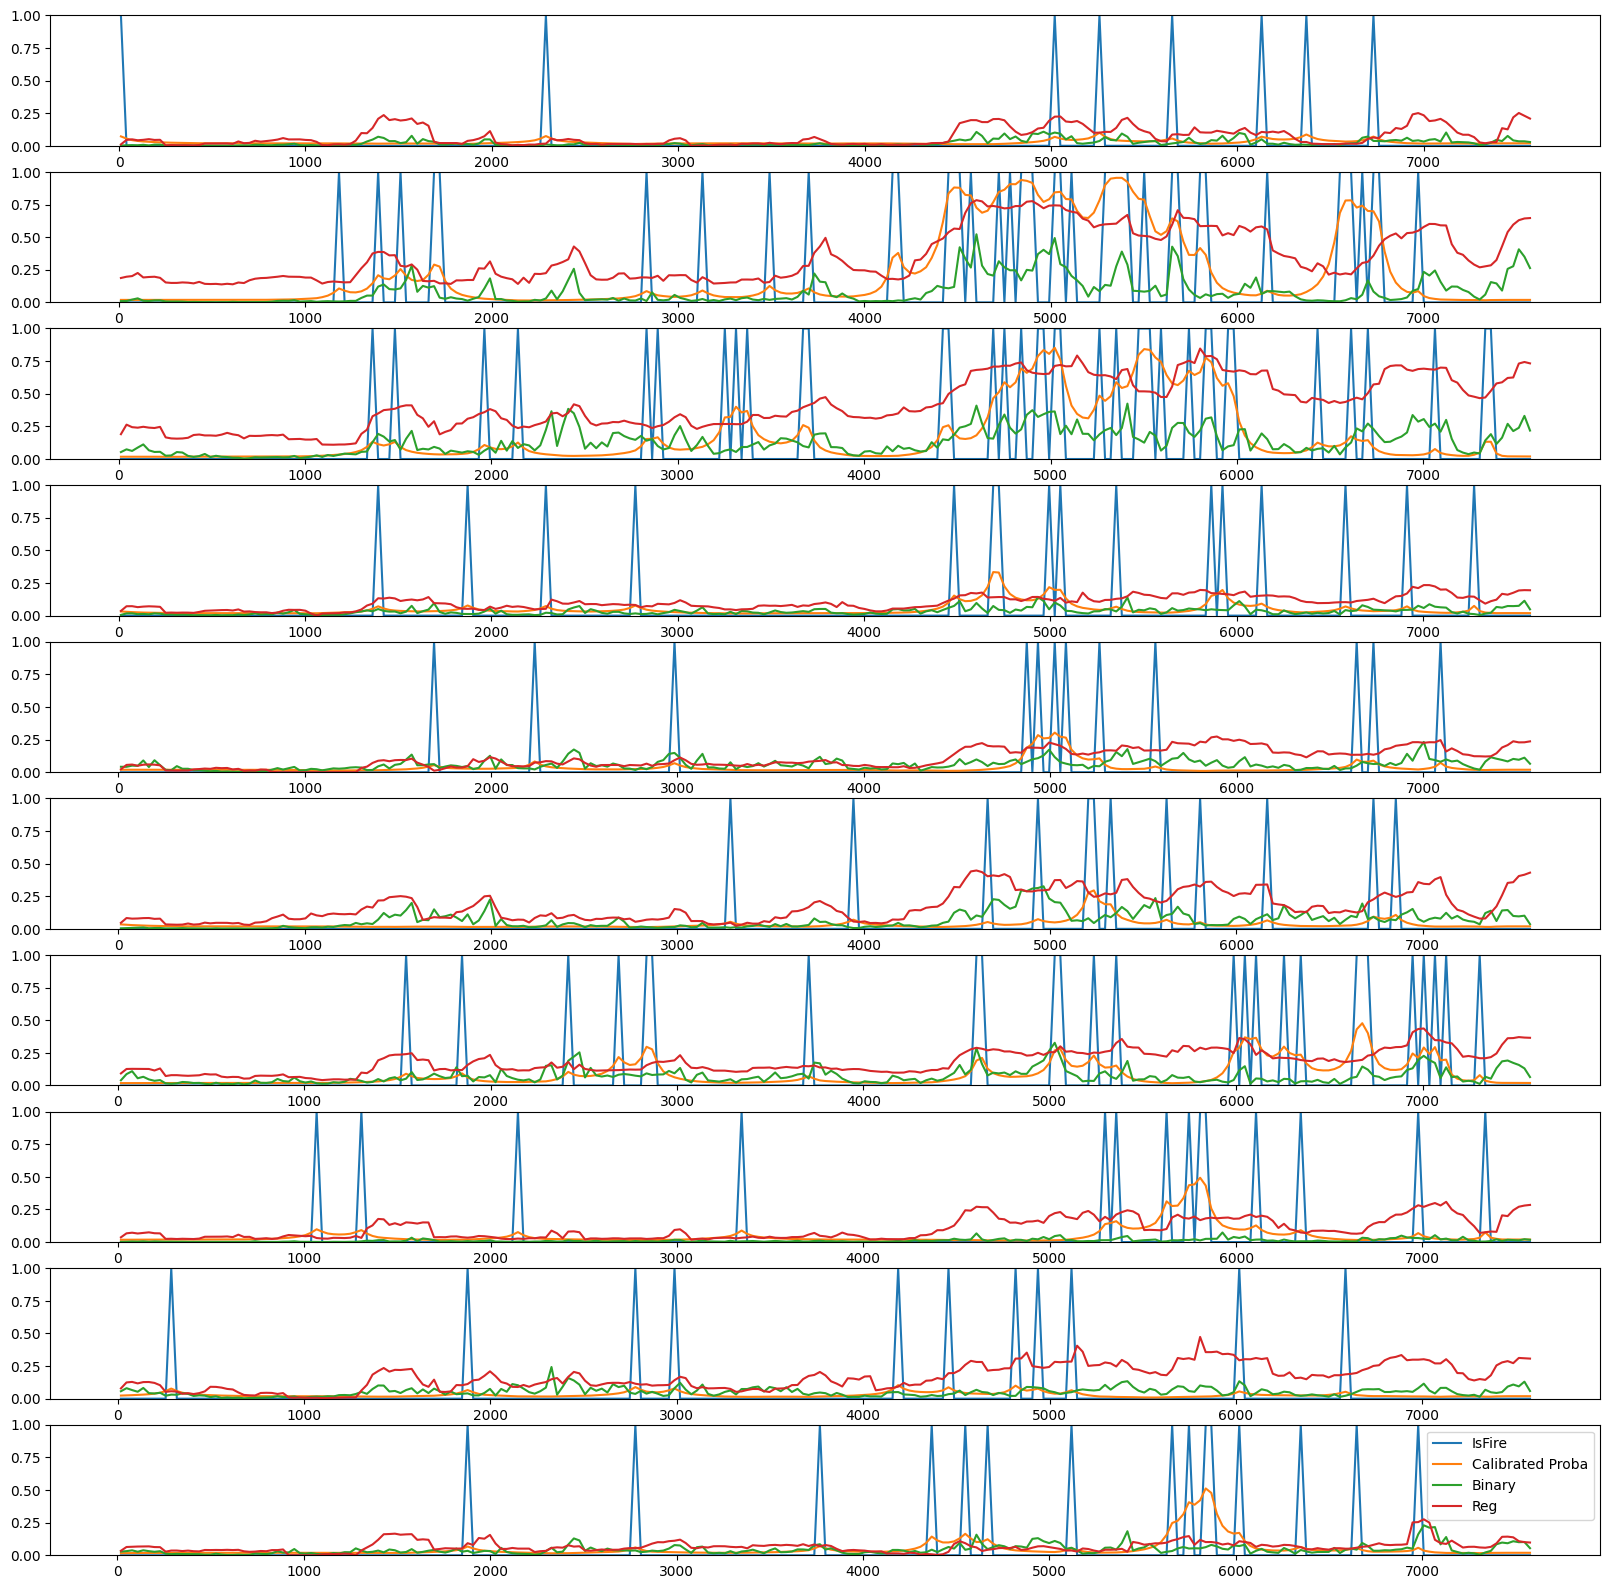

In [ ]:
dataset252 = dataset[(dataset['departement'] == 25)]

clusterId = dataset252['cluster'].unique()

fig, ax = plt.subplots(len(clusterId), figsize = (20,20))

for i, cID in enumerate(clusterId):
    ax[i].set_ylim([0, 1])
    dataset252_ = dataset252[(dataset252['cluster'] == cID)]
    ax[i].plot(dataset252_.index.values, dataset252_.isFire.values, label='IsFire')
    ax[i].plot(dataset252_.index.values, dataset252_.calibratedProba.values, label='Calibrated Proba')
    ax[i].plot(dataset252_.index.values, dataset252_.predict_binary.values, label='Binary')
    ax[i].plot(dataset252_.index.values, dataset252_.predict_reg.values, label='Reg')
    #ax[i].plot(dataset252_.index.values, dataset252_.predict_multi_class.values, label='Multi class')
    #ax[i].set_xticks(rotation=45, ha='right')
plt.legend()

In [ ]:
dataset.departement.unique()

array([ 1, 25, 78])

In [ ]:
"""dataset252 = dataset[(dataset['departement'] == 78)]

clusterId = dataset252['cluster'].unique()

fig, ax = plt.subplots(len(clusterId), figsize = (20,20))

for i, cID in enumerate(clusterId):
    dataset252_ = dataset252[(dataset252['cluster'] == cID)]
    ax[i].set_ylim([0, 1])
    ax[i].plot(dataset252_.index.values, dataset252_.isFire.values, label='IsFire')
    ax[i].plot(dataset252_.index.values, dataset252_.classCalibratedProba.values, label='Calibrated Proba')
    ax[i].plot(dataset252_.index.values, dataset252_.predict_binary.values, label='Binary')
    ax[i].plot(dataset252_.index.values, dataset252_.predict_reg.values, label='Reg')
    #ax[i].plot(dataset252_.index.values, dataset252_.predict_multi_class.values, label='Multi class')
    #ax[i].set_xticks(rotation=45, ha='right')
plt.legend()"""

"dataset252 = dataset[(dataset['departement'] == 78)]\n\nclusterId = dataset252['cluster'].unique()\n\nfig, ax = plt.subplots(len(clusterId), figsize = (20,20))\n\nfor i, cID in enumerate(clusterId):\n    dataset252_ = dataset252[(dataset252['cluster'] == cID)]\n    ax[i].set_ylim([0, 1])\n    ax[i].plot(dataset252_.index.values, dataset252_.isFire.values, label='IsFire')\n    ax[i].plot(dataset252_.index.values, dataset252_.classCalibratedProba.values, label='Calibrated Proba')\n    ax[i].plot(dataset252_.index.values, dataset252_.predict_binary.values, label='Binary')\n    ax[i].plot(dataset252_.index.values, dataset252_.predict_reg.values, label='Reg')\n    #ax[i].plot(dataset252_.index.values, dataset252_.predict_multi_class.values, label='Multi class')\n    #ax[i].set_xticks(rotation=45, ha='right')\nplt.legend()"

### Metrics

In [ ]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, \
roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, brier_score_loss, log_loss, mean_squared_error, mean_pinball_loss
import CRPS.CRPS as pscore

def calcul_score(test, classification, binary, quantile, target, pred, alpha):
    if classification:

        if not binary:

            precision = []
            recall = []
            f1 = []
            accuracy = []
            roc_auc = []
            matrix = []
            rmse = []
            firelogloss = []
            logloss = []

            fire = test[(test['isFire'] == 1)]

            loglossProba = np.zeros(shape=(len(test), 2))
            loglossProba[:,0] = 1 - test['predict_multi_class'].values
            loglossProba[:,1] = test['predict_multi_class'].values

            loglossProbaFire = np.zeros(shape=(len(fire), 2))
            loglossProbaFire[:,0] = 1 - fire['predict_multi_class'].values
            loglossProbaFire[:,1] = fire['predict_multi_class'].values

            matrix.append(confusion_matrix(test[target], test[pred], normalize='true'))
            precision.append(precision_score(test[target], test[pred], average='macro', sample_weight=test['weights_binary']))
            recall.append(recall_score(test[target], test[pred], average='macro', sample_weight=test['weights_binary']))
            f1.append(f1_score(test[target], test[pred], average='macro', sample_weight=test['weights_binary']))
            accuracy.append(accuracy_score(test[target], test[pred], sample_weight=test['weights_binary']))
            rmse.append(math.sqrt(mean_squared_error(test['classCalibratedProba'], test['predict_multi_class'], sample_weight=test['weights_binary'])))

            logloss.append(log_loss(test['isFire'].values, loglossProba, sample_weight=test['weights_binary']))
            firelogloss.append(log_loss(fire['isFire'].values, loglossProbaFire, labels=[0, 1], sample_weight=fire['weights_binary']))
            try:
                roc_auc.append(roc_auc_score(test[target], test['pred'], average='macro'))
            except:
                roc_auc = 0

            dico = {'precision': precision, 'recall' : recall, 'f1 score': f1, 'accuracy': accuracy, 'roc_auc': roc_auc, 'rmse':rmse, 'logloss':logloss, 'firelogloss': firelogloss}
            df_metrics = pd.DataFrame.from_dict(dico)
            return df_metrics, matrix

        else:
            precision = []
            recall = []
            f1 = []
            accuracy = []
            roc_auc = []
            matrix = []
            logloss = []
            BrierScore = []
            fireBrierScore = []
            firelogloss = []
            ece = []

            rmse = []
            crps = []
            fcrps = []
            acrps = []

            fire = test[(test[target] == 1)]

            loglossProba = np.zeros(shape=(len(test), 2))
            loglossProba[:,0] = 1 - test['predict_binary'].values
            loglossProba[:,1] = test['predict_binary'].values

            loglossProbaFire = np.zeros(shape=(len(fire), 2))
            loglossProbaFire[:,0] = 1 - fire['predict_binary'].values
            loglossProbaFire[:,1] = fire['predict_binary'].values

            matrix.append(confusion_matrix(test[target], test[pred], normalize='true'))
            precision.append(precision_score(test[target], test[pred], average='macro', sample_weight=test['weights_binary']))
            recall.append(recall_score(test[target], test[pred], average='macro', sample_weight=test['weights_binary']))
            f1.append(f1_score(test[target], test[pred], average='macro', sample_weight=test['weights_binary']))
            accuracy.append(accuracy_score(test[target], test[pred], sample_weight=test['weights_binary']))
            BrierScore.append(brier_score_loss(test[target], test['predict_binary'], sample_weight=test['weights_binary']))
            fireBrierScore.append(brier_score_loss(fire[target], fire['predict_binary'], sample_weight=fire['weights_binary']))


            logloss.append(log_loss(test[target].values, loglossProba, sample_weight=test['weights_binary']))
            firelogloss.append(log_loss(fire[target].values, loglossProbaFire, labels=[0, 1], sample_weight=fire['weights_binary']))
            #ece.append(expected_calibration_error(test[target], test['proba'], sample_weight=test['weights']))
            rmse.append(math.sqrt(mean_squared_error(test['calibratedProba'], test[pred], sample_weight=test['weights_binary'])))
            
            try:
                roc_auc.append(roc_auc_score(test[target], test['pred'], average='macro'))
            except:
                roc_auc = 0

            dico = {'precision': precision, 'recall' : recall, 'f1 score': f1, 'accuracy': accuracy, 'roc_auc': roc_auc, 'logloss' : logloss, 'firelogloss': firelogloss,
                    'BrierScore' : BrierScore, 'fireBrierScore' : fireBrierScore, 'rmse' : rmse}
            df_metrics = pd.DataFrame.from_dict(dico)
            return df_metrics, matrix
    else:
        if quantile:
            for al in alpha:
                mbl = []
                mbl.append(mean_pinball_loss(test[target], test['pred_'+str(al)], alpha=al))
                dico = {'mbl_'+str(al): mbl}

            df_metrics = pd.DataFrame.from_dict(dico)
            return df_metrics, []
        else:
            rmse = []
            crps = []
            fcrps = []
            acrps = []
            firelogloss = []
            logloss = []

            fire = test[(test['isFire'] == 1)]

            loglossProba = np.zeros(shape=(len(test), 2))
            loglossProba[:,0] = 1 - test['predict_reg'].values
            loglossProba[:,1] = test['predict_reg'].values

            loglossProbaFire = np.zeros(shape=(len(fire), 2))
            loglossProbaFire[:,0] = 1 - fire['predict_reg'].values
            loglossProbaFire[:,1] = fire['predict_reg'].values

            for index, row in test.iterrows():
                crpsval, fcrpsval, acrpsval = pscore(test[target], row['predict_reg'], len(test)).compute()
                crps.append(crpsval)
                fcrps.append(fcrpsval)
                acrps.append(acrpsval)

            crps = [np.mean(crps)]
            fcrps = [np.mean(fcrps)]
            acrps = [np.mean(acrps)]

            rmse.append(math.sqrt(mean_squared_error(test[target], test['predict_reg'], sample_weight=test['weights_binary'])))

            logloss.append(log_loss(test['isFire'].values, loglossProba, sample_weight=test['weights_binary']))
            firelogloss.append(log_loss(fire['isFire'].values, loglossProbaFire, labels=[0, 1], sample_weight=fire['weights_binary']))
            dico = {'rmse': rmse, 'crps' : crps,
            'fcrps': fcrps, 'acrps' : acrps, 'logloss': logloss, 'firelogloss': firelogloss}

            df_metrics = pd.DataFrame.from_dict(dico)
            return df_metrics, []
      

In [ ]:
#df_metrics_multi_class, matrix_multi_class = calcul_score(dataset, True, False, False, 'classCalibrated', 'class_multi_class', [])
df_metrics_binary, matrix_binary = calcul_score(dataset, True, True, False, 'isFire', 'isFirePred', [])
df_metrics_reg, _ = calcul_score(dataset, False, False, False, 'calibratedProba', 'predict_reg', [])
#df_metrics_quantile, _ = calcul_score(dataset, False, False, True, 'calibratedProba', 'predict_', [0.05,0.5,0.95])

/home/caron/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/caron/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [ ]:
"""display(df_metrics_multi_class)
ConfusionMatrixDisplay(matrix_multi_class[-1]).plot()"""

'display(df_metrics_multi_class)\nConfusionMatrixDisplay(matrix_multi_class[-1]).plot()'

,precision,recall,f1 score,accuracy,roc_auc,logloss,firelogloss,BrierScore,fireBrierScore,rmse
0,0.685518,0.512108,0.364439,0.514455,0,1.236529,2.391639,0.378355,0.744319,0.316247


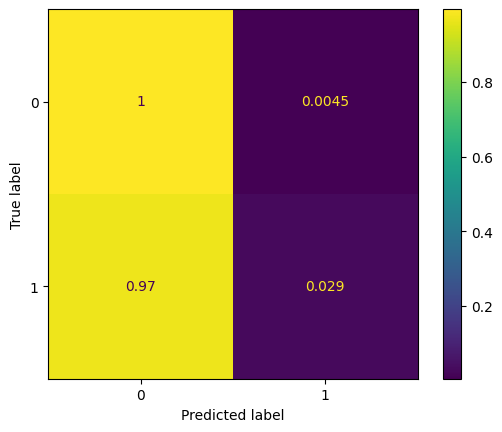

In [ ]:
display(df_metrics_binary)
ConfusionMatrixDisplay(matrix_binary[-1]).plot()

In [ ]:
display(df_metrics_reg)

,rmse,crps,fcrps,acrps,logloss,firelogloss
0,0.224764,0.127742,0.127735,0.127742,0.852143,1.477101


0.1444910104567685 0.44453363551114006
0.005881092451673843 0.4211062695306204


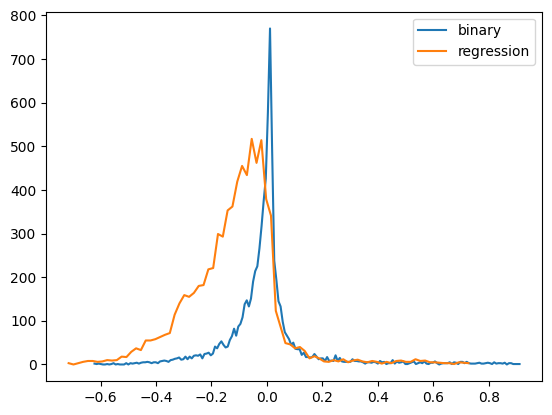

In [ ]:
#difmu = dataset.classCalibratedProba - dataset.predict_multi_class
difbin = dataset.calibratedProba - dataset.predict_binary
difreg = dataset.calibratedProba - dataset.predict_reg


hist, bin_edges = np.histogram(difbin, bins='auto')
bin_edges = (bin_edges + np.roll(bin_edges, -1))[:-1] / 2.0
print(bin_edges.mean(), bin_edges.std())
plt.plot(bin_edges, hist, label = 'binary')

hist, bin_edges = np.histogram(difreg, bins='auto')
bin_edges = (bin_edges + np.roll(bin_edges, -1))[:-1] / 2.0
print(bin_edges.mean(), bin_edges.std())
plt.plot(bin_edges, hist, label='regression')

plt.legend()

0.774638295173645 0.0


/home/caron/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


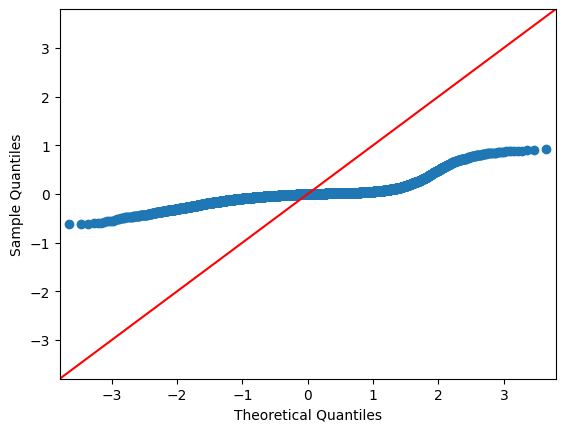

In [ ]:
import statsmodels.api as sm
from scipy import stats

statistic, pvalue = stats.shapiro(difbin)
print(statistic, pvalue)

fig = sm.qqplot(difbin, line='45')
plt.show()

0.9266006350517273 0.0


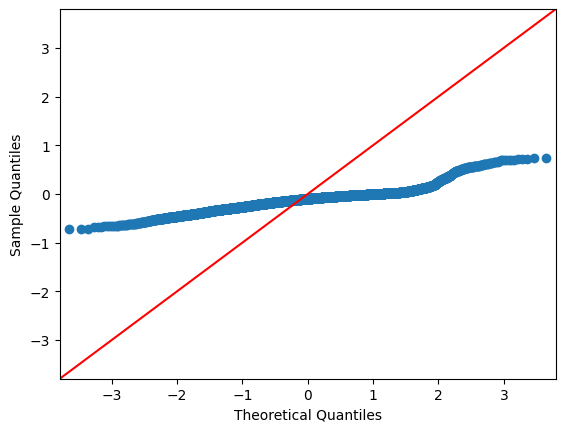

In [ ]:
statistic, pvalue = stats.shapiro(difreg)
print(statistic, pvalue)

fig = sm.qqplot(difreg, line='45')
plt.show()

### Calibration

/tmp/ipykernel_8441/3521379626.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("Dark2")


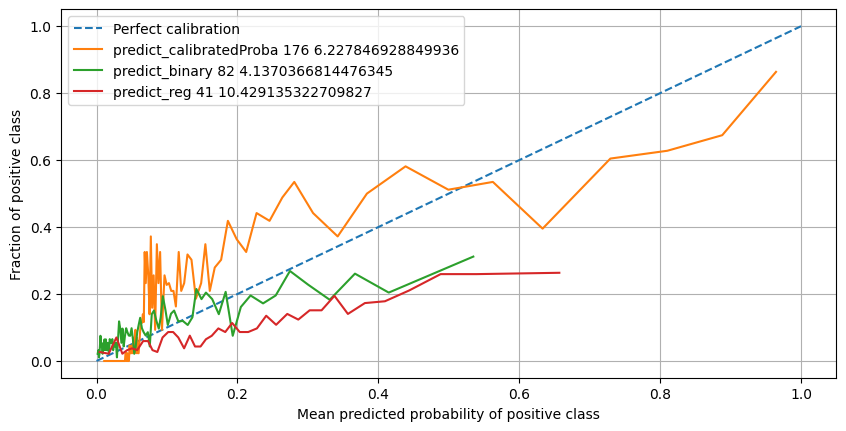

In [ ]:
from sklearn.linear_model import LogisticRegression
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10,10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
ax_calibration_curve.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect calibration')

n_bins, ece = expected_calibration_error(dataset['isFire'].values, dataset['calibratedProba'].values)
y_means, proba_means = calibration_curve(dataset['isFire'].values, dataset['calibratedProba'].values, n_bins=n_bins, strategy='quantile')
ax_calibration_curve.plot(proba_means, y_means, label='predict_calibratedProba ' + str(n_bins) + " " + str(ece))

n_bins, ece = expected_calibration_error(dataset['isFire'].values, dataset['predict_binary'].values)
y_means, proba_means = calibration_curve(dataset['isFire'].values, dataset['predict_binary'].values, n_bins=n_bins, strategy='quantile')
ax_calibration_curve.plot(proba_means, y_means, label='predict_binary ' + str(n_bins) + " " + str(ece))

"""n_bins, ece = expected_calibration_error(dataset['isFire'].values, dataset['predict_multi_class'].values)
y_means, proba_means = calibration_curve(dataset['isFire'].values, dataset['predict_multi_class'].values, n_bins=n_bins, strategy='quantile')
ax_calibration_curve.plot(proba_means, y_means, label='predict_multi_class ' + str(n_bins) + " " + str(ece))"""

n_bins, ece = expected_calibration_error(dataset['isFire'].values, dataset['predict_reg'].values)
y_means, proba_means = calibration_curve(dataset['isFire'].values, dataset['predict_reg'].values, n_bins=n_bins, strategy='quantile')
ax_calibration_curve.plot(proba_means, y_means, label='predict_reg ' + str(n_bins) + " " + str(ece))

ax_calibration_curve.set(xlabel="Mean predicted probability of positive class", ylabel="Fraction of positive class")
ax_calibration_curve.grid()
#ax_calibration_curve.set_title("Calibration plots")
ax_calibration_curve.legend()

plt.savefig(dir_dataset / 'calibration_study_2023.png')

In [ ]:
df_metrics_multi_class, matrix_multi_class = calcul_score(unknowdataset, True, False, False, 'classCalibrated', 'class_multi_class', [])
df_metrics_binary, matrix_binary = calcul_score(unknowdataset, True, True, False, 'isFire', 'isFirePred', [])
df_metrics_reg, _ = calcul_score(unknowdataset, False, False, False, 'calibratedProba', 'predict_reg', [])

NameError: name 'unknowdataset' is not defined

,precision,recall,f1 score,accuracy,roc_auc,rmse,logloss,firelogloss
0,0.676981,0.604193,0.631738,0.724591,0,0.304103,1.006117,1.84563


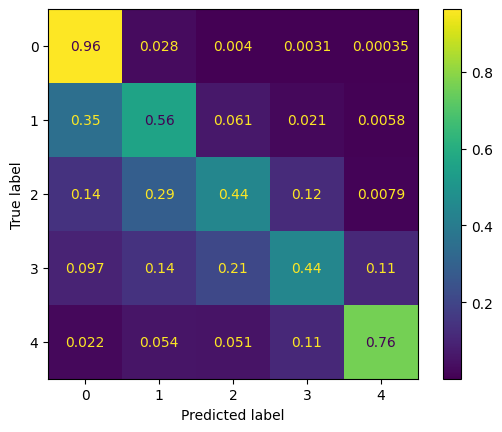

In [ ]:
display(df_metrics_multi_class)
ConfusionMatrixDisplay(matrix_multi_class[-1]).plot()

,precision,recall,f1 score,accuracy,roc_auc,logloss,firelogloss,BrierScore,fireBrierScore,rmse
0,0.704331,0.527292,0.396589,0.527292,0,1.016286,1.933328,0.341232,0.667169,0.343863


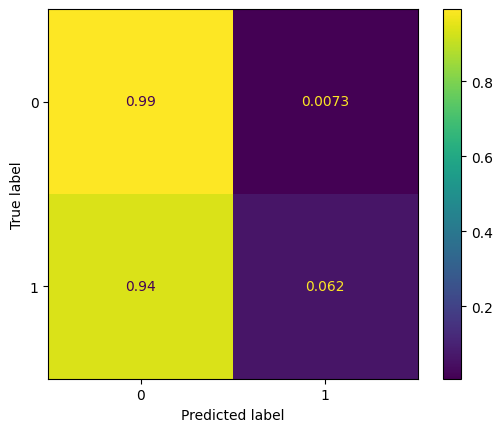

In [ ]:
display(df_metrics_binary)
ConfusionMatrixDisplay(matrix_binary[-1]).plot()

In [ ]:
display(df_metrics_reg)

,rmse,crps,fcrps,acrps,logloss,firelogloss
0,0.122912,0.063462,0.063456,0.063462,0.963464,1.829325


/tmp/ipykernel_6144/680577550.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("Dark2")


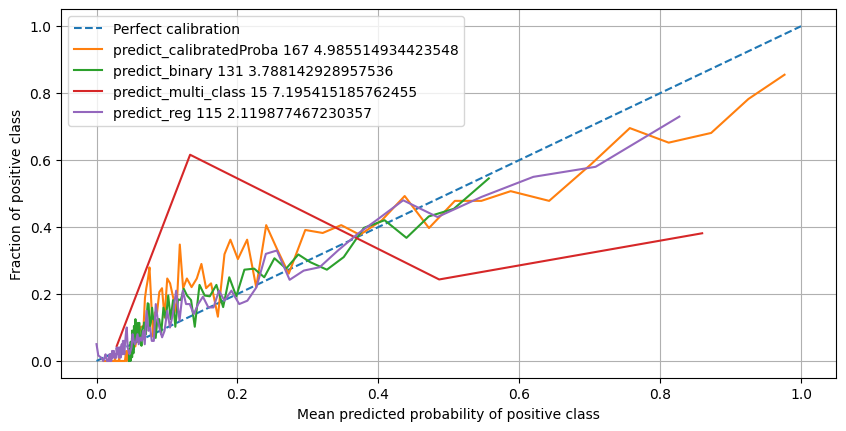

In [ ]:
from sklearn.linear_model import LogisticRegression
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10,10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
ax_calibration_curve.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect calibration')

n_bins, ece = expected_calibration_error(unknowdataset['isFire'].values, unknowdataset['calibratedProba'].values)
y_means, proba_means = calibration_curve(unknowdataset['isFire'].values, unknowdataset['calibratedProba'].values, n_bins=n_bins, strategy='quantile')
ax_calibration_curve.plot(proba_means, y_means, label='predict_calibratedProba ' + str(n_bins) + " " + str(ece))

n_bins, ece = expected_calibration_error(unknowdataset['isFire'].values, unknowdataset['predict_binary'].values)
y_means, proba_means = calibration_curve(unknowdataset['isFire'].values, unknowdataset['predict_binary'].values, n_bins=n_bins, strategy='quantile')
ax_calibration_curve.plot(proba_means, y_means, label='predict_binary ' + str(n_bins) + " " + str(ece))

n_bins, ece = expected_calibration_error(unknowdataset['isFire'].values, unknowdataset['predict_multi_class'].values)
y_means, proba_means = calibration_curve(unknowdataset['isFire'].values, unknowdataset['predict_multi_class'].values, n_bins=n_bins, strategy='quantile')
ax_calibration_curve.plot(proba_means, y_means, label='predict_multi_class ' + str(n_bins) + " " + str(ece))

n_bins, ece = expected_calibration_error(unknowdataset['isFire'].values, unknowdataset['predict_reg'].values)
y_means, proba_means = calibration_curve(unknowdataset['isFire'].values, unknowdataset['predict_reg'].values, n_bins=n_bins, strategy='quantile')
ax_calibration_curve.plot(proba_means, y_means, label='predict_reg ' + str(n_bins) + " " + str(ece))

ax_calibration_curve.set(xlabel="Mean predicted probability of positive class", ylabel="Fraction of positive class")
ax_calibration_curve.grid()
#ax_calibration_curve.set_title("Calibration plots")
ax_calibration_curve.legend()

plt.savefig(dir_dataset / 'calibration_study_unknow_2023.png')

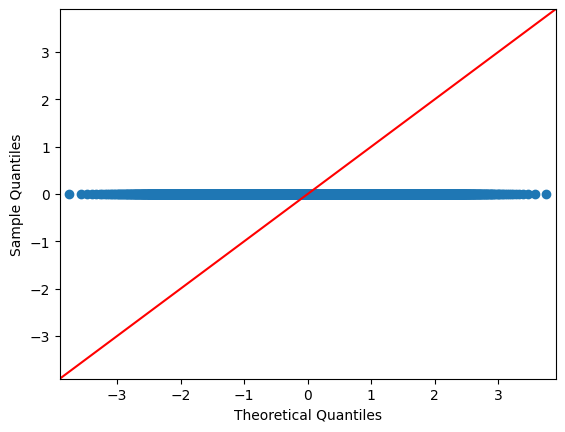

In [ ]:
import statsmodels.api as sm

fig = sm.qqplot(abs(unknowdataset.predict_reg - unknowdataset.predict_reg), line='45')
plt.show()